# Compare Custom Vision and Image Clustering Skill

This notebook will help you to compare the usage of Custom Vision service and Image Clustering Skill. It also contains a great example of Python SDK usage. 

Now we create a label file for our clusters with inuitive search terms that will help our users easily find this 
data. If using your own data, find meaningful labels that faciliate how your users will search for this data.

Here the dictionary key relates to the cluster id, and multiple labels can be applied to each cluster

In [19]:
import pickle

label_file_name = "labels.pkl"

# 0 is the cluster id
dict = {2 : ['book cover', 'closed book'], 1 : ['open book', 'double spread'], 0: ['book shelf', 'library']}
f = open(f"../custom-skills-deployment/models/{label_file_name}","wb")  # We are saving the file to our models directory
pickle.dump(dict,f)
f.close()

## Test the deployed inference API Web App 

In [43]:
from requests import post, put
import json

KEY= "[YourSecretKeyCanBeAnything]" # Set the KEY value you deployed your Web App with [YourSecretKeyCanBeAnything]
WEB_APP_URL = "https://[].azurewebsites.net"  # This is the deployed web app format: URL https://[appname].azurewebsites.net
result_response = ""

headers = {
    "Ocp-Apim-Subscription-Key": KEY,     
    "Content-Type": "application/json",

}

with open("../data/postman_request.json") as f:
    text = json.load(f)
    


try:
    url = f"{WEB_APP_URL}/api/extraction"
    resp = post(url=url, json=text, headers=headers)
    
    result_response = resp.json()
    if resp.status_code == 403:
        print("Authorisation Failed: Check that your KEY value is the same as on the web app setting KEY")
        
    if len(result_response['values'][0]['data']['label']) > 0:
        print(f"API deployed successfully - predicted label is {result_response['values'][0]['data']['label']}")

except Exception as e:
    print('Exception calling Web App', e)


API deployed successfully - predicted label is ['open book', 'double spread']


# Deploy the PowerSkill to Azure Search

* The first step is to upload the data files in the data folder to a container in Azure blob storage and
get the connection values to create the ACS data source.
* You will need your [ACS API Key](https://docs.microsoft.com/en-us/azure/search/search-security-api-keys)
and the URL for your ACS instance. 

# Create the data source

In [48]:
# Let's create a data source
API_KEY = ""   # Your ACS API Key
ACS_URL = "https://[].search.windows.net"   # Your ACS URL format https://[your ACS instance].search.windows.net
DATA_SOURCE = "clustering-datasourcepr"  # The name for your data source

json_text = {
    "name" : DATA_SOURCE,
    "type" : "azureblob",
    "credentials" : { "connectionString" : ""},    #  This is your azure blob connection string
    "container" : { "name" : "books" }  # The name of the container where the data files are
}

headers = {
    "api-key": API_KEY,     
    "Content-Type": "application/json",

}

try:
    url = f"{ACS_URL}/datasources?api-version=2020-06-30"
    resp = post(url=url, json=json_text, headers=headers)
    
    result_response = resp.json()
    if resp.status_code == 403:
        print("Authorisation Failed: Check that your API KEY value is correct")
        
        
    if resp.status_code == 201:
        print("Success creating data source")
        
except Exception as e:
    print('Exception creating data source', e)

201


# Now we create the index

In [50]:
INDEX_NAME = "clustering-indexpr"  # The name for the index

json_text = {
      "name" : INDEX_NAME,
      "fields": [
        { "name": "id", "type": "Edm.String", "key": "true", "searchable": "false" },
        { "name": "url", "type": "Edm.String", "searchable": "true" },
        { "name": "file_name", "type": "Edm.String", "searchable": "false" },
        { "name": "size", "type": "Edm.Int64", "searchable": "false" },
        { "name": "last_modified", "type": "Edm.DateTimeOffset", "searchable": "false" },
        { "name": "content", "type": "Edm.String", "searchable": "true", "filterable": "false", "sortable": "false", "facetable": "false" },
        { "name": "label", "type": "Collection(Edm.String)", "searchable": "true", "filterable": "false", "sortable": "false", "facetable": "false" }
      ]
}

try:
    url = f"{ACS_URL}/indexes?api-version=2020-06-30"
    resp = post(url=url, json=json_text, headers=headers)
    
    result_response = resp.json()
    if resp.status_code == 403:
        print("Authorisation Failed: Check that your API KEY value is correct")
        
        
    if resp.status_code == 201:
        print("Success creating index")
        
except Exception as e:
    print('Exception creating index', e)

Success creating index


# Now we create the skill set

In [75]:
# Note we are passing in the secret header key and the inference API URL to the skillset
SKILLSET_NAME = "testclusteringskillset"  # The name of your skillset
COGSVC_KEY = ""  #  This is your Cognitive Services key that resides in the same region as ACS (used to compare custom vision captions and object detection)

json_text = {
    "description": "Cluster images for labelling",
    "skills": [
        {
            "@odata.type": "#Microsoft.Skills.Custom.WebApiSkill",
            "description": "A custom skill that can cluster and auto label images",
            "uri": f"{WEB_APP_URL}/api/extraction",
            "timeout": "PT160S",
            "batchSize": 1,
            "context": "/document/normalized_images/*",
            "httpHeaders": {
                "Ocp-Apim-Subscription-Key": KEY
            },
            "httpMethod": "POST",
            "inputs": [
            {
                "name": "images",
                "source": "/document/normalized_images/*"
            }
            ],
            "outputs": [
                {
                    "name": "label"
                }
            ]
        }
    ],
    "cognitiveServices": {
        "@odata.type": "#Microsoft.Azure.Search.CognitiveServicesByKey",
        "description": "cogsvc",
        "key": COGSVC_KEY
    }
}


try:
    url = f"{ACS_URL}/skillsets/{SKILLSET_NAME}?api-version=2020-06-30"
    resp = put(url=url, json=json_text, headers=headers)
    
    result_response = resp.json()
    if resp.status_code == 403:
        print("Authorisation Failed: Check that your API KEY value is correct")

    if resp.status_code == 201:
        print("Success creating skillset")
        
except Exception as e:
    print('Exception creating skillset', e)


Success creating skillset


# Now we create the indexer

In [76]:
json_text = {
    "name": "clustering-indexerpr",
    "dataSourceName": DATA_SOURCE,
    "targetIndexName": INDEX_NAME,
    "skillsetName": SKILLSET_NAME,
    "parameters": {
    "configuration": {
      "allowSkillsetToReadFileData": "true",
      "imageAction": "generateNormalizedImages"
    }
    },
    "outputFieldMappings": [
        {
            "sourceFieldName": "/document/normalized_images/*/label",
            "targetFieldName": "label"
        }
    ]

}


try:
    url = f"{ACS_URL}/indexers?api-version=2020-06-30"
    resp = post(url=url, json=json_text, headers=headers)
    
    result_response = resp.json()
    if resp.status_code == 403:
        print("Authorisation Failed: Check that your API KEY value is correct")

    if resp.status_code == 201:
        print("Success creating indexer")
        
except Exception as e:
    print('Exception creating indexer', e)

Success creating indexer


## Test the cluster labels in Azure Search queries

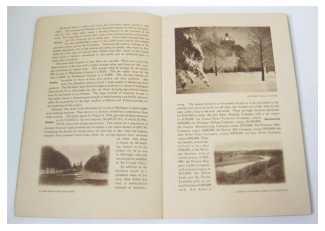

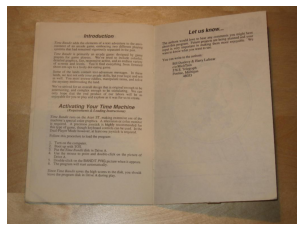

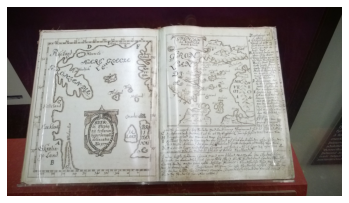

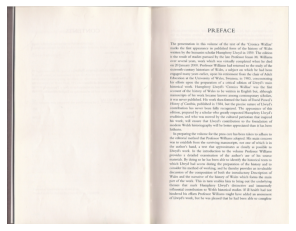

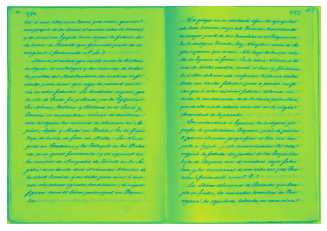

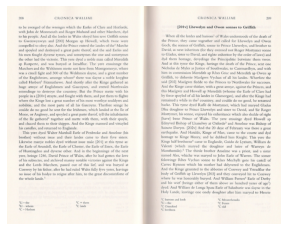

In [93]:
import os
from azure.core.credentials import AzureKeyCredential
from azure.search.documents import SearchClient
import base64
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt

# Get the service endpoint and API key from the environment
endpoint = ACS_URL
key = API_KEY
# Enter your search term here e.g. open or closed or bookshelf
search_term = "open"
return_n_matches = 6   # Number of results to return

# Create a client
credential = AzureKeyCredential(key)
client = SearchClient(endpoint=endpoint,
                      index_name=INDEX_NAME,
                      credential=credential)


results = client.search(search_text=search_term, top=return_n_matches)

for result in results:
    book = str(base64.urlsafe_b64decode(result["id"].strip() + "=="))
    book_index = book.find("books/")
    try:
        image_path = "../data/train/" + book[book_index+6:-3]
    except Exception as FileNotFound:
        image_path = "../data/test/" + book[book_index+6:-3]
    image_data = open(image_path, "rb").read()
    image = Image.open(BytesIO(image_data))
    plt.imshow(image)
    plt.axis("off")
    _ = plt.title("", size="x-large", y=-0.1)
    plt.show()